In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import torch.optim as optim
import pickle
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, inCh, outCh, stride):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(in_channels=inCh, out_channels=outCh,
                            kernel_size=3, padding=1, stride=stride),
            nn.BatchNorm2d(outCh),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=outCh, out_channels=outCh,
                            kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(outCh)
        )

        self.shortcut = nn.Sequential()
        if stride != 1 or inCh != outCh:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels=inCh, out_channels=outCh,
                            kernel_size=1, stride=stride),
                nn.BatchNorm2d(outCh)
            )

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer_1 = self.make_layer(ResidualBlock, 64, 64, stride=1)
        self.layer_2 = self.make_layer(ResidualBlock, 64, 128, stride=2)
        self.layer_3 = self.make_layer(ResidualBlock, 128, 256, stride=2)
        self.layer_4 = self.make_layer(ResidualBlock, 256, 512, stride=2)
        self.avgpool = nn.AvgPool2d((3, 3), stride=2)
        self.fc = nn.Linear(512 * 1 * 1, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        x = self.avgpool(x)
        x = x.view(-1, 512*1*1)
        x = self.fc(x)
        return x

    def make_layer(self, block, inCh, outCh, stride, block_num=2):
        layers = []
        layers.append(block(inCh, outCh, stride))
        for i in range(block_num - 1):
            layers.append(block(outCh, outCh, 1))
        return nn.Sequential(*layers)

In [3]:
batchsize=256
worker=2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]
transform_norm = transforms.Normalize(mean, std)

state_dict = torch.load('model_automobile_pup_05.pt',map_location=torch.device('cpu'))
model_cnn_robust = ResNet18().to(device)
model_cnn_robust.load_state_dict(state_dict)

transform = transforms.Compose(
    [transforms.RandomCrop(32, padding=4),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor()])
transform_test = transforms.Compose(
    [transforms.ToTensor()])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

/home/pedro.zanineli/anaconda3/envs/ilumpy/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Files already downloaded and verified
Files already downloaded and verified


In [4]:
def epoch(loader, model, opt=None, lr_scheduler=None):
    """Standard training/evaluation epoch over the dataset"""
    total_loss, total_err = 0., 0.
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        X = transform_norm(X)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp, y)
        
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()

        if lr_scheduler:
            lr_scheduler.step()
        
        total_err += (yp.max(dim=1)[1] == y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

def pgd_linf(model, X, y, epsilon=8.0/255.0, alpha=0.01, num_iter=20, randomize=False):
    """ Construct FGSM adversarial examples on the examples X"""
    if randomize:
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(X, requires_grad=True)

    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(transform_norm(X + delta)), y)
        loss.backward()
        delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-epsilon, epsilon)
        delta.grad.zero_()
    return delta.detach()

def epoch_adversarial(loader, model, attack, opt=None, **kwargs):
    """Adversarial training/evaluation epoch over the dataset"""
    total_loss, total_err = 0., 0.
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        # with adversarial example
        delta = attack(model, X, y, **kwargs)
        adv = transform_norm(X + delta)
        yp = model(adv)
        loss = nn.CrossEntropyLoss()(yp, y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        total_err += (yp.max(dim=1)[1] == y).sum().item()
        total_loss += loss.item() * X.shape[0]

    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [5]:
initial_lr = 0.25

In [6]:
airplane_idx_test = np.where((np.array(testset.targets) == 0))[0]
airplane_ds_test = torch.utils.data.Subset(testset, airplane_idx_test)
airplane_dl_test = torch.utils.data.DataLoader(airplane_ds_test, batch_size=256, shuffle=True, num_workers=worker)

train_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True, num_workers=worker)
test_loader = DataLoader(testset, batch_size=batchsize, shuffle=False, num_workers=worker)

###
# initial_lr = 0.001
optimizer = optim.Adam(model_cnn_robust.parameters(), lr=initial_lr)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

###
test_err, test_loss = epoch(airplane_dl_test, model_cnn_robust, opt=optimizer, lr_scheduler=lr_scheduler)
###

adv_err, adv_loss = epoch_adversarial(airplane_dl_test, model_cnn_robust, pgd_linf)

test_err_0 = test_err
adv_err_0 = adv_err

print('AIRPLANE')
print(f'Test Acc: {test_err}; Adversarial Acc: {adv_err}')
print(f'Test Loss: {test_loss}; Adversarial Loss: {adv_loss}')

AIRPLANE
Test Acc: 0.812; Adversarial Acc: 1.0
Test Loss: 0.9399564819335937; Adversarial Loss: 0.0


In [7]:
automobile_idx_test = np.where((np.array(testset.targets) == 1))[0]
automobile_ds_test = torch.utils.data.Subset(testset, automobile_idx_test)
automobile_dl_test = torch.utils.data.DataLoader(automobile_ds_test, batch_size=256, shuffle=True, num_workers=worker)

###
# initial_lr = 0.001
optimizer = optim.Adam(model_cnn_robust.parameters(), lr=initial_lr)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

###
test_err, test_loss = epoch(automobile_dl_test, model_cnn_robust, opt=optimizer, lr_scheduler=lr_scheduler)
###

adv_err, adv_loss = epoch_adversarial(automobile_dl_test, model_cnn_robust, pgd_linf)

test_err_1 = test_err
adv_err_1 = adv_err

print('AUTOMOBILE')
print(f'Test Acc: {test_err}; Adversarial Acc: {adv_err}')
print(f'Test Loss: {test_loss}; Adversarial Loss: {adv_loss}')

AUTOMOBILE
Test Acc: 0.226; Adversarial Acc: 1.0
Test Loss: 183.35882655715943; Adversarial Loss: 1.526018319129944


In [8]:
bird_idx_test = np.where((np.array(testset.targets) == 2))[0]
bird_ds_test = torch.utils.data.Subset(testset, bird_idx_test)
bird_dl_test = torch.utils.data.DataLoader(bird_ds_test, batch_size=256, shuffle=True, num_workers=worker)

###
# initial_lr = 0.001
optimizer = optim.Adam(model_cnn_robust.parameters(), lr=initial_lr)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

###
test_err, test_loss = epoch(bird_dl_test, model_cnn_robust, opt=optimizer, lr_scheduler=lr_scheduler)
###

adv_err, adv_loss = epoch_adversarial(bird_dl_test, model_cnn_robust, pgd_linf)

test_err_2 = test_err
adv_err_2 = adv_err

print('BIRD')
print(f'Test Acc: {test_err}; Adversarial Acc: {adv_err}')
print(f'Test Loss: {test_loss}; Adversarial Loss: {adv_loss}')

BIRD
Test Acc: 0.487; Adversarial Acc: 1.0
Test Loss: 2.35090109705925; Adversarial Loss: 0.06509679329395295


In [9]:
cat_idx_test = np.where((np.array(testset.targets) == 3))[0]
cat_ds_test = torch.utils.data.Subset(testset, cat_idx_test)
cat_dl_test = torch.utils.data.DataLoader(cat_ds_test, batch_size=256, shuffle=True, num_workers=worker)

###
# initial_lr = 0.001
optimizer = optim.Adam(model_cnn_robust.parameters(), lr=initial_lr)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

###
test_err, test_loss = epoch(cat_dl_test, model_cnn_robust, opt=optimizer, lr_scheduler=lr_scheduler)
###

adv_err, adv_loss = epoch_adversarial(cat_dl_test, model_cnn_robust, pgd_linf)

test_err_3 = test_err
adv_err_3 = adv_err

print('CAT')
print(f'Test Acc: {test_err}; Adversarial Acc: {adv_err}')
print(f'Test Loss: {test_loss}; Adversarial Loss: {adv_loss}')

CAT
Test Acc: 0.049; Adversarial Acc: 0.118
Test Loss: 4.368292244911194; Adversarial Loss: 1.2161717948913575


In [10]:
deer_idx_test = np.where((np.array(testset.targets) == 4))[0]
deer_ds_test = torch.utils.data.Subset(testset, deer_idx_test)
deer_dl_test = torch.utils.data.DataLoader(deer_ds_test, batch_size=256, shuffle=True, num_workers=worker)

###
# initial_lr = 0.001
optimizer = optim.Adam(model_cnn_robust.parameters(), lr=initial_lr)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

###
test_err, test_loss = epoch(deer_dl_test, model_cnn_robust, opt=optimizer, lr_scheduler=lr_scheduler)
###

adv_err, adv_loss = epoch_adversarial(deer_dl_test, model_cnn_robust, pgd_linf)

test_err_4 = test_err
adv_err_4 = adv_err

print('DEER')
print(f'Test Acc: {test_err}; Adversarial Acc: {adv_err}')
print(f'Test Loss: {test_loss}; Adversarial Loss: {adv_loss}')

DEER
Test Acc: 0.021; Adversarial Acc: 1.0
Test Loss: 3.2803458070755003; Adversarial Loss: 1.3832365493774414


In [11]:
dog_idx_test = np.where((np.array(testset.targets) == 5))[0]
dog_ds_test = torch.utils.data.Subset(testset, dog_idx_test)
dog_dl_test = torch.utils.data.DataLoader(dog_ds_test, batch_size=256, shuffle=True, num_workers=worker)

###
# initial_lr = 0.001
optimizer = optim.Adam(model_cnn_robust.parameters(), lr=initial_lr)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

###
test_err, test_loss = epoch(dog_dl_test, model_cnn_robust, opt=optimizer, lr_scheduler=lr_scheduler)
###

adv_err, adv_loss = epoch_adversarial(dog_dl_test, model_cnn_robust, pgd_linf)

test_err_5 = test_err
adv_err_5 = adv_err

print('DOG')
print(f'Test Acc: {test_err}; Adversarial Acc: {adv_err}')
print(f'Test Loss: {test_loss}; Adversarial Loss: {adv_loss}')

DOG
Test Acc: 0.0; Adversarial Acc: 0.0
Test Loss: 2.8405668029785156; Adversarial Loss: 1.7601167907714843


In [12]:
frog_idx_test = np.where((np.array(testset.targets) == 6))[0]
frog_ds_test = torch.utils.data.Subset(testset, frog_idx_test)
frog_dl_test = torch.utils.data.DataLoader(frog_ds_test, batch_size=256, shuffle=True, num_workers=worker)

###
# initial_lr = 0.001
optimizer = optim.Adam(model_cnn_robust.parameters(), lr=initial_lr)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

###
test_err, test_loss = epoch(frog_dl_test, model_cnn_robust, opt=optimizer, lr_scheduler=lr_scheduler)
###

adv_err, adv_loss = epoch_adversarial(frog_dl_test, model_cnn_robust, pgd_linf)

test_err_6 = test_err
adv_err_6 = adv_err

print('FROG')
print(f'Test Acc: {test_err}; Adversarial Acc: {adv_err}')
print(f'Test Loss: {test_loss}; Adversarial Loss: {adv_loss}')

FROG
Test Acc: 0.0; Adversarial Acc: 0.0
Test Loss: 2.6655545291900635; Adversarial Loss: 1.740650733947754


In [13]:
horse_idx_test = np.where((np.array(testset.targets) == 7))[0]
horse_ds_test = torch.utils.data.Subset(testset, horse_idx_test)
horse_dl_test = torch.utils.data.DataLoader(horse_ds_test, batch_size=256, shuffle=True, num_workers=worker)

###
# initial_lr = 0.001
optimizer = optim.Adam(model_cnn_robust.parameters(), lr=initial_lr)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

###
test_err, test_loss = epoch(horse_dl_test, model_cnn_robust, opt=optimizer, lr_scheduler=lr_scheduler)
###

adv_err, adv_loss = epoch_adversarial(horse_dl_test, model_cnn_robust, pgd_linf)

test_err_7 = test_err
adv_err_7 = adv_err

print('HORSE')
print(f'Test Acc: {test_err}; Adversarial Acc: {adv_err}')
print(f'Test Loss: {test_loss}; Adversarial Loss: {adv_loss}')

HORSE
Test Acc: 0.0; Adversarial Acc: 0.0
Test Loss: 2.914882604598999; Adversarial Loss: 1.9700232524871826


In [14]:
ship_idx_test = np.where((np.array(testset.targets) == 8))[0]
ship_ds_test = torch.utils.data.Subset(testset, ship_idx_test)
ship_dl_test = torch.utils.data.DataLoader(ship_ds_test, batch_size=256, shuffle=True, num_workers=worker)

###
# initial_lr = 0.001
optimizer = optim.Adam(model_cnn_robust.parameters(), lr=initial_lr)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

###
test_err, test_loss = epoch(ship_dl_test, model_cnn_robust, opt=optimizer, lr_scheduler=lr_scheduler)
###

adv_err, adv_loss = epoch_adversarial(ship_dl_test, model_cnn_robust, pgd_linf)

test_err_8 = test_err
adv_err_8 = adv_err

print('SHIP')
print(f'Test Acc: {test_err}; Adversarial Acc: {adv_err}')
print(f'Test Loss: {test_loss}; Adversarial Loss: {adv_loss}')

SHIP
Test Acc: 0.232; Adversarial Acc: 1.0
Test Loss: 2.6692487697601317; Adversarial Loss: 0.3880627381801605


In [ ]:
truck_idx_test = np.where((np.array(testset.targets) == 9))[0]
truck_ds_test = torch.utils.data.Subset(testset, truck_idx_test)
truck_dl_test = torch.utils.data.DataLoader(truck_ds_test, batch_size=256, shuffle=True, num_workers=worker)

###
# initial_lr = 0.001
optimizer = optim.Adam(model_cnn_robust.parameters(), lr=initial_lr)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

###
test_err, test_loss = epoch(truck_dl_test, model_cnn_robust, opt=optimizer, lr_scheduler=lr_scheduler)
###

adv_err, adv_loss = epoch_adversarial(truck_dl_test, model_cnn_robust, pgd_linf)

test_err_9 = test_err
adv_err_9 = adv_err

print('TRUCK')
print(f'Test Acc: {test_err}; Adversarial Acc: {adv_err}')
print(f'Test Loss: {test_loss}; Adversarial Loss: {adv_loss}')

In [ ]:
y = np.array([adv_err_0, adv_err_1, adv_err_2, adv_err_3, adv_err_4, adv_err_5, adv_err_6, adv_err_7, adv_err_8, adv_err_9])

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,6))

x = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

plt.bar(x, y)
plt.xticks(rotation = 45)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.axhline(y=y.min(), color='r', linestyle='-', linewidth=3)
plt.axhline(y=y.mean(), color='k', linestyle='-', linewidth=3)

plt.ylabel('Robust test accuracy',fontsize=18)
plt.title('Adversarial training (50% data selection)\n',fontsize=20,loc='left')

# plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
plt.ylim(0,1)
plt.savefig('./figs/lr=0.25.png',dpi=500)
plt.show()

# 

In [22]:
print('Label,')
for label, test_acc in zip(['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck'],[test_err_0, test_err_1, test_err_2, test_err_3, test_err_4, test_err_5, test_err_6, test_err_7, test_err_8, test_err_9]):
    print(f'{label},{test_acc}')

Label,
Airplane,0.73
Automobile,0.575
Bird,0.469
Cat,0.554
Deer,0.108
Dog,0.147
Frog,0.035
Horse,0.053
Ship,0.021
Truck,0.069


In [24]:
print('Label,')
for label, adv_acc in zip(['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck'],[adv_err_0, adv_err_1, adv_err_2, adv_err_3, adv_err_4, adv_err_5, adv_err_6, adv_err_7, adv_err_8, adv_err_9]):
    print(f'{label},{adv_acc}')

Label,
Airplane,0.973
Automobile,0.992
Bird,0.926
Cat,0.999
Deer,0.517
Dog,0.342
Frog,0.103
Horse,0.13
Ship,0.118
Truck,0.267


# 

In [17]:
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

automobile_idx_test = np.where((np.array(testset.targets) == 1))[0]
automobile_ds_test = torch.utils.data.Subset(testset, automobile_idx_test)
automobile_dl_test = torch.utils.data.DataLoader(automobile_ds_test, batch_size=256, shuffle=False, num_workers=worker)

automobile_idx_train = np.where((np.array(trainset.targets) == 1))[0]
automobile_ds_train = torch.utils.data.Subset(trainset, automobile_idx_train)
automobile_dl_train = torch.utils.data.DataLoader(automobile_ds_train, batch_size=256, shuffle=False, num_workers=worker)

Files already downloaded and verified
Files already downloaded and verified


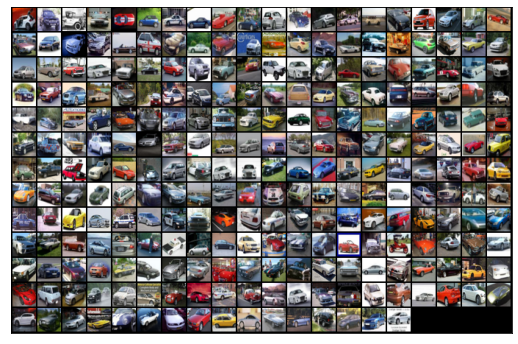

In [18]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

for images, labels in automobile_dl_test:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=20).permute(1, 2, 0))
    break

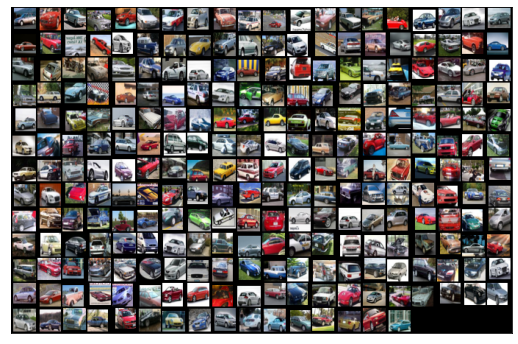

In [19]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

for images, labels in automobile_dl_train:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=20).permute(1, 2, 0))
    break

In [20]:
for data, targets in automobile_dl_train:
    print(targets)
    break

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
